# 🎯 Project: The Automated Task Manager

Welcome to your hands-on AI application build! Today, you aren't just writing code; you are building a tool that solves a common corporate headache: turning messy meeting minutes into assigned tasks.

## The Workflow
We will follow the exact same path a Machine Learning Engineer takes:

- Exploration: Understanding the relationship between task descriptions and employees.

- Training: Experimenting with "Brains" (Classifiers) like SVMs and Neural Networks to see which one "learns" best.

- Deployment: Wrapping your best model into a professional-looking web application that runs directly in this notebook.

## The Problem
Our organization has a historical dataset of tasks assigned to specific employees. We want to automate the assignment of new tasks extracted from future meeting minutes.

In [1]:
#@title ⚙️ Setup: install required packages and download project data { display-mode: "form" }
!pip install pandas numpy matplotlib seaborn scikit-learn torch

import os
import requests
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive', force_remount=True)

def download_github_files(branch, folder_path, files):
    """
    Downloads a list of files from a specific GitHub branch into a Drive folder.
    """
    # Ensure the directory exists
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"✅ Created directory: {folder_path}")

    base_url = f"https://raw.githubusercontent.com/eth-bmai-fs26/project/refs/heads/{branch}/week1/task_meeting/data"

    for file_name in files:
        url = f"{base_url}/{file_name}"
        destination = os.path.join(folder_path, file_name)

        try:
            response = requests.get(url)
            if response.status_code == 200:
                with open(destination, "wb") as f:
                    f.write(response.content)
                print(f"📥 Successfully saved: {file_name}")
            else:
                print(f"❌ Failed to download {file_name} (Status: {response.status_code})")
        except Exception as e:
            print(f"⚠️ Error downloading {file_name}: {e}")

# --- CONFIGURATION ---
BRANCH = "week1/task_meeting"
DATASET_FOLDER = "/content/drive/MyDrive/BMAI/week1/task_meeting/data"

# List your 4 files here
files_to_download = [
    "employee_tasks_meeting_id.pkl",
    "employee_tasks_meeting_id_transcripts.pkl",
]

# Run the download
download_github_files(BRANCH, DATASET_FOLDER, files_to_download)

Mounted at /content/drive
📥 Successfully saved: employee_tasks_meeting_id.pkl
📥 Successfully saved: employee_tasks_meeting_id_transcripts.pkl


## 📊 Section 1: Data Exploration
Before training our AI model, we first need to understand the data it will learn from. In our dataset, each row represents a real work task. It contains:

*   Task Description: The actual text (e.g., "Review the employment contracts").
*   Employee ID: The unique number for that role. This is the target label the model actually learns to predict.
* Role: The job title or department (e.g., "HR Specialist"). This is the human-readable label.
*   Task Embedding: The numerical representation of the task. (Think of this as the "computer-readable" version of the sentence).


🎯 Our goal is to train an AI system that can learn patterns from past tasks and make intelligent assignments in the future. But before training the model, we must check whether our data is fair, balanced, and meaningful.

### ⚖️ Data Balance Check

How many tasks does each employee have? Are they equally represented?

Your Task: Run the code cell below and calculate the number of tasks assigned to each employee.

💡 Why this matters?

If "Employee A" has 90% of the tasks, the AI may learn to assign most new tasks to "Employee A", simply because that was the most common pattern in the past.

This means the AI would rely on historical frequency rather than truly understanding the task description. Therefore, we aim for a dataset where every employee has a similar number of tasks.


### 📊 Dataset Overview
| Metric | Value |
| :--- | :--- |
| **Total Rows (Tasks)** | 1750 |
| **Total Columns** | 5 |
| **Missing Values** | 0 |

#### 📋 Column Details:
| Column Name | Data Type |
| :--- | :--- |
| **task_description** | `object` |
| **task_embedding** | `object` |
| **role** | `object` |
| **employee_id** | `int64` |
| **meeting_id** | `int64` |



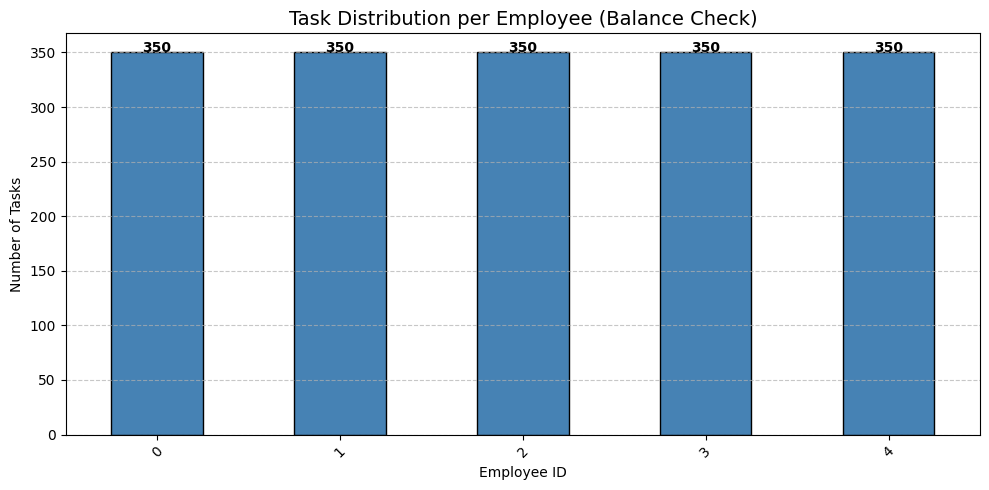

⚖️ Imbalance Ratio: 1.00 (1.00 is perfect balance)


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

df = pd.read_pickle(os.path.join(DATASET_FOLDER, 'employee_tasks_meeting_id.pkl'))

# ---------------------------------------------------------
# 📊 SECTION A: DATASET OVERVIEW
# ---------------------------------------------------------

# Generate a Markdown table for Column Names & Types
col_table = "| Column Name | Data Type |\n| :--- | :--- |\n"
for col_name, dtype in df.dtypes.items():
    col_table += f"| **{col_name}** | `{dtype}` |\n"

# Create the main Overview String
overview_text = f"""
### 📊 Dataset Overview
| Metric | Value |
| :--- | :--- |
| **Total Rows (Tasks)** | {df.shape[0]} |
| **Total Columns** | {df.shape[1]} |
| **Missing Values** | {df.isnull().sum().sum()} |

#### 📋 Column Details:
{col_table}
"""

# Render the Markdown
display(Markdown(overview_text))

# We create a dictionary from the dataframe to map ID numbers back to Role names
id_to_role = df.set_index('employee_id')['role'].to_dict()

# ---------------------------------------------------------
# 🔢 SECTION B: TASKS PER EMPLOYEE (Array & Distribution)
# ---------------------------------------------------------

# 1. Get the counts
employee_counts = df['employee_id'].value_counts()

# Create a clean plot
fig, ax = plt.subplots(figsize=(10, 5))
employee_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')

ax.set_title(f"Task Distribution per Employee (Balance Check)", fontsize=14)
ax.set_ylabel("Number of Tasks")
ax.set_xlabel("Employee ID")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for i, v in enumerate(employee_counts):
    ax.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Final Imbalance Check
imbalance_ratio = employee_counts.max() / employee_counts.min()
print(f"⚖️ Imbalance Ratio: {imbalance_ratio:.2f} (1.00 is perfect balance)")

In [3]:
# Analyze task descriptions
print("=== Task Description Analysis ===")

if 'task_description' in df.columns:
    # Text length distribution
    df['text_length'] = df['task_description'].str.len()
    df['word_count'] = df['task_description'].str.split().str.len()

    print(f"Text length stats:\n{df['text_length'].describe()}")
    print(f"\nWord count stats:\n{df['word_count'].describe()}")

    # Sample tasks per role
    print("\n=== Sample Tasks per Role ===")
    if 'role' in df.columns:
        for role in df['role'].unique()[:5]:
            print(f"\n--- {role} ---")
            samples = df[df['role'] == role]['task_description'].head(3).tolist()
            for s in samples:
                print(f"  • {s[:100]}...")

=== Task Description Analysis ===
Text length stats:
count    1750.000000
mean       53.026286
std         6.285325
min        26.000000
25%        49.000000
50%        53.000000
75%        57.000000
max        77.000000
Name: text_length, dtype: float64

Word count stats:
count    1750.000000
mean        8.070286
std         0.938459
min         4.000000
25%         8.000000
50%         8.000000
75%         9.000000
max        12.000000
Name: word_count, dtype: float64

=== Sample Tasks per Role ===

--- backend_dev ---
  • Scale the payment gateway using Docker containers....
  • Optimize the RESTful interface for the v2 migration....
  • Architect the API endpoints for the v2 migration....

--- customer_support ---
  • Follow up on the bug report to the technical team....
  • Walk through the enterprise account for the VIP client....
  • Walk through the subscription cancellation with the manager's approval....

--- data_scientist ---
  • Model the regression baseline to support the

💡 Note: How can the AI understand task descriptions?

The answer is embeddings.

Embeddings convert each task description into numbers that capture its meaning, not just its appearance.

This allows the AI to recognize patterns and relationships between tasks based on their content.

Importantly, because embeddings capture meaning and context, the AI does not rely on simplistic rules, such as:

* assigning tasks based only on the length of the description
* matching specific keywords to specific employees

Instead, the AI learns to interpret the overall meaning of the task, which leads to more accurate and reliable predictions!

## 📦 Data Preparation
Now we prepare the data for machine learning:
1. Define features (X) and target (y)
    * Input (X): The task_embedding (the numerical "meaning" of the task).

    * Target (y): The employee_id (values 0–4). Since these are already numbers—and therefore understandable by computers—we can use them directly.

2. Split into Train/Test Sets
    * We divide the data so we have one set to teach the model (Train) and a separate hidden set to evaluate it later (Test).

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# 1. Define Features (X) and Target (y)
# We stack the embedding lists into a matrix (Rows=Tasks, Cols=Dimensions)
X = np.vstack(df['task_embedding'].values)
y = df['employee_id']  # Already 0-4, so no encoding needed

# 2. Split into Train/Test Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Ensures we keep the class balance in both sets
)

# We numpy to find the unique labels and count them
unique_classes, counts = np.unique(y_train, return_counts=True)

print(f"✅ Data Prepared Successfully!")
print(f"Training on {len(X_train)} tasks.")
print(f"Testing on {len(X_test)} tasks.")

print("\n--- Samples per Class ---")
for cls, count in zip(unique_classes, counts):
    print(f"Class {cls}: {count} tasks")

✅ Data Prepared Successfully!
Training on 1400 tasks.
Testing on 350 tasks.

--- Samples per Class ---
Class 0: 280 tasks
Class 1: 280 tasks
Class 2: 280 tasks
Class 3: 280 tasks
Class 4: 280 tasks


## PCA - [TODO] Explanation

💡 INTERPRETING THIS CHART:
   - Each dot is one task.
   - Dots that are close together have similar MEANINGS.
   - If the colors are well-separated, the AI finds the task easy.
   - If colors mix/overlap, those are the confusing tasks!

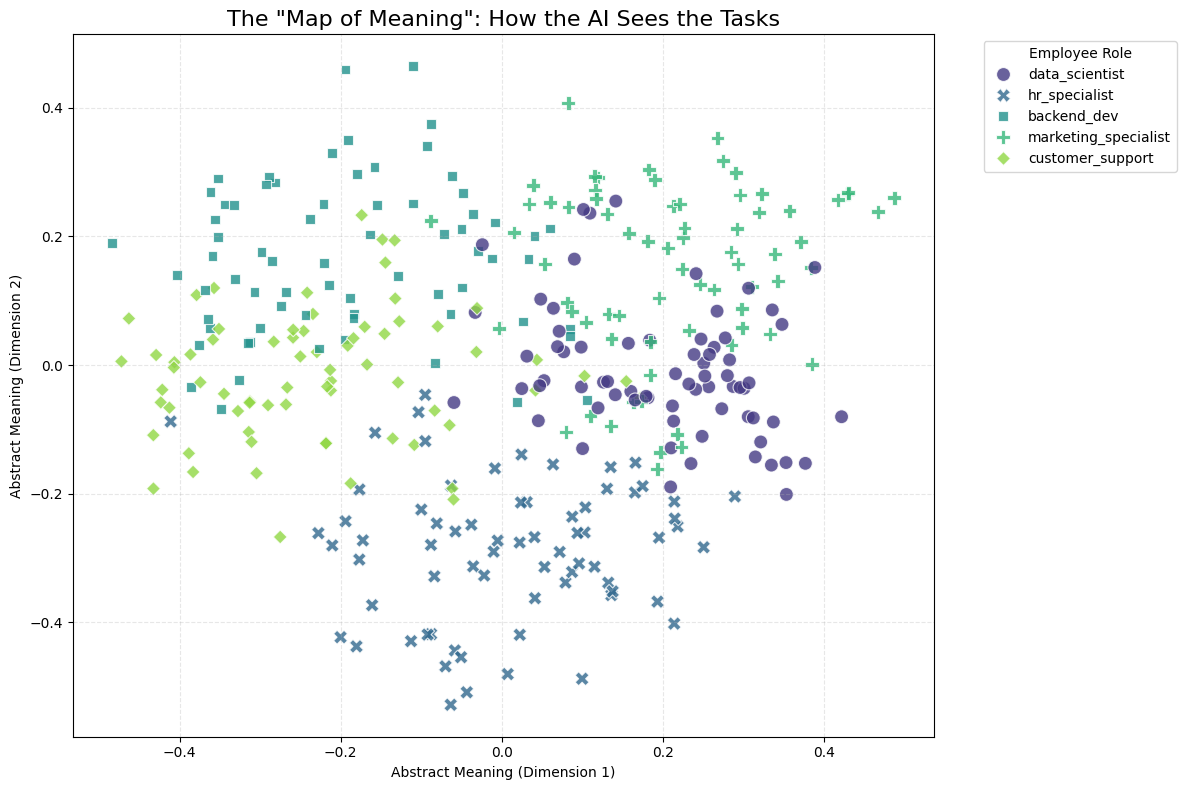

In [5]:
#@title Visualize the data in PCA { display-mode: "form" }
# ============================================================
#
# We use PCA (Principal Component Analysis) to squash the
# 384-dimensional vectors down to 2D so we can draw them.
# ============================================================

from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Squash the data to 2 Dimensions (2D)
pca = PCA(n_components=2)
X_embedded_2d = pca.fit_transform(X_test)

# 2. Create a temporary DataFrame for plotting
# We use the 'id_to_role' dictionary to get the actual names
role_names = [id_to_role[i] for i in y_test]

df_viz = pd.DataFrame(X_embedded_2d, columns=['Dimension 1', 'Dimension 2'])
df_viz['Role'] = role_names

# 3. Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_viz,
    x='Dimension 1',
    y='Dimension 2',
    hue='Role',      # Color points by Role
    style='Role',    # Different shapes for different roles
    s=100,           # Size of dots
    alpha=0.8,       # Transparency
    palette='viridis'
)

plt.title('The "Map of Meaning": How the AI Sees the Tasks', fontsize=16)
plt.xlabel('Abstract Meaning (Dimension 1)')
plt.ylabel('Abstract Meaning (Dimension 2)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Employee Role")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## 🧠 Section 2: Now we train our model!

We will now use the emb column as our input ($X$) and the emp_id as our target ($y$).
Neural Networks are powerful but can "overfit" (memorize) small datasets. SVMs are more robust for smaller samples. Maybe Random forests are better. Which one performs better on our test data?

## Section 2.1 - YOUR TASK - Try using SVMs?

### What is a SVM
 ---------------
 Imagine you have a bunch of colored dots floating in space.
 An SVM (Support Vector Machine) draws the BEST possible line (or sheet) to separate the colors.

 For example, if you have red dots (Backend Developers) and blue dots
 (HR Specialists), the SVM finds where to draw a line so that all
 red dots are on one side and blue dots on the other.

 ### What is a kernel
-------------------
 A kernel is the "shape" of the boundary the SVM draws:
 - LINEAR kernel = straight line (or flat plane in our embedding space)
 - RBF kernel = curved/wavy line (we'll try this next)

 ### What is the $C$ parameter?
 --------------------------
 $C$ controls how strict the SVM is:
 - Low $C$ (e.g., 0.1): Draws a simpler line, okay with some mistakes
 - High $C$ (e.g., 10): Tries VERY hard to get every point right
 - $C=1$: A balanced middle ground (what we use here)

🏋️ Training SVM with Linear Kernel...
✅ Training completed in 0.28 seconds

📊 RESULTS: Linear SVM
Accuracy: 0.9657 (96.6%)

Detailed Metrics per Role:
                      precision    recall  f1-score   support

         backend_dev       0.96      1.00      0.98        70
    customer_support       0.93      0.93      0.93        70
      data_scientist       1.00      0.99      0.99        70
       hr_specialist       0.98      0.93      0.96        70
marketing_specialist       0.96      0.99      0.97        70

            accuracy                           0.97       350
           macro avg       0.97      0.97      0.97       350
        weighted avg       0.97      0.97      0.97       350



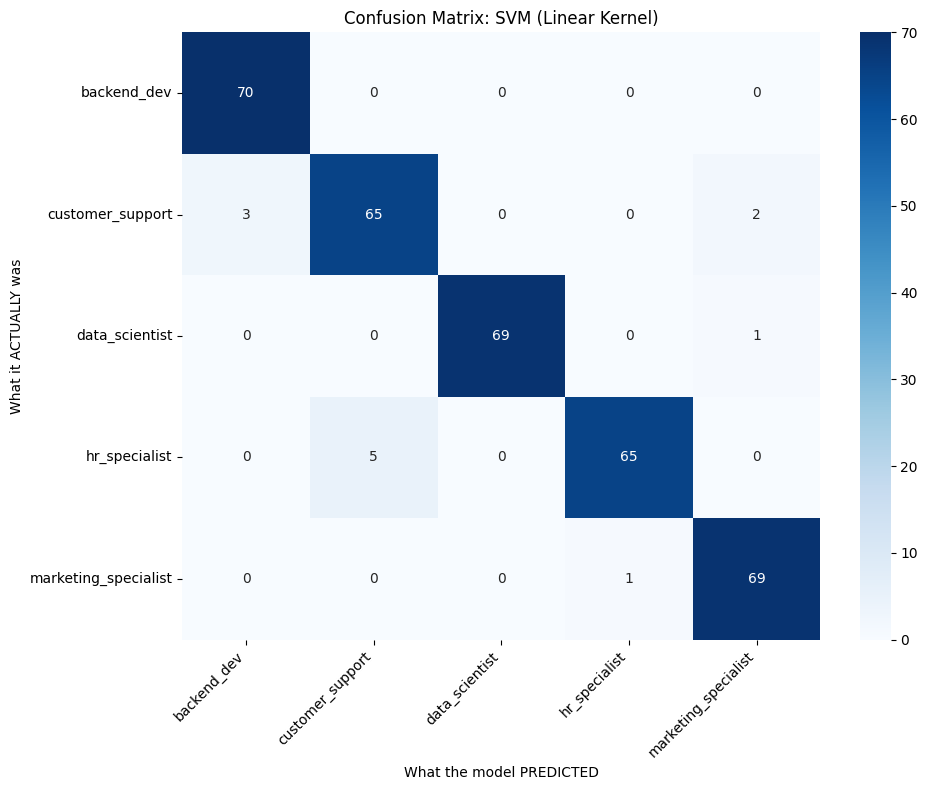

In [6]:
# ============================================================
# SUPPORT VECTOR MACHINE (SVM) - LINEAR KERNEL
# ============================================================

from sklearn.svm import SVC  # SVC = Support Vector Classifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import time

# --- STEP 1: Create the model ---
# We're telling Python: "I want an SVM with a straight-line boundary"
svm_linear = SVC(
    kernel='linear',    # Use straight-line boundaries to cut through the embedding space
    C=1.0,              # Balanced strictness
    random_state=42     # Makes results reproducible
)

# --- STEP 2: Train the model ---
# "Training" = showing the model many examples so it learns the pattern.
# X_train contains the TASK EMBEDDINGS (numerical meaning of the text).
# y_train contains the correct answers (employee IDs).
print("🏋️ Training SVM with Linear Kernel...")
start_time = time.time()

svm_linear.fit(X_train, y_train)  # <-- This is where learning happens!

training_time = time.time() - start_time
print(f"✅ Training completed in {training_time:.2f} seconds")

# --- STEP 3: Make predictions on test data ---
# Now we test: can the model correctly classify tasks it has NEVER seen?
# X_test contains new task embeddings the model wasn't trained on.
y_pred_linear = svm_linear.predict(X_test)

# --- STEP 4: Evaluate performance ---
# "Accuracy" = percentage of correct predictions
accuracy = accuracy_score(y_test, y_pred_linear)

print(f"\n📊 RESULTS: Linear SVM")
print(f"{'='*50}")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")

# Get the list of role names in the correct order (0, 1, 2, 3...)
# We use the 'id_to_role' dictionary created in the Data Prep step
target_names = [id_to_role[i] for i in sorted(id_to_role.keys())]

# Classification report shows detailed stats for each role:
# - Precision: When it predicts "Doctor", how often is it right?
# - Recall: Out of all actual Doctors, how many did it find?
print(f"\nDetailed Metrics per Role:")
print(classification_report(y_test, y_pred_linear, target_names=target_names))

# --- STEP 5: Visualize with a confusion matrix ---
# A confusion matrix shows WHERE the model makes mistakes:
# - Rows = what the task ACTUALLY is
# - Columns = what the model PREDICTED
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_linear)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)

plt.title('Confusion Matrix: SVM (Linear Kernel)')
plt.xlabel('What the model PREDICTED')
plt.ylabel('What it ACTUALLY was')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Warn if accuracy is suspiciously high
if accuracy > 0.99:
    print("\n⚠️ NOTE: Accuracy > 99% is very high!")
    print("   This is expected here because Embeddings capture MEANING.")
    print("   The model can easily separate 'Medical' concepts from 'IT' concepts")
    print("   because they live in different parts of the vector space.")

## Section 2.2 - YOUR TASK - Try using Random Forests?
### WHAT IS A RANDOM FOREST?
 ------------------------
 Imagine asking 100 different people to guess something.
 Each person might make mistakes, but if you take the MAJORITY vote,
 you'll usually get the right answer!

 That's exactly what a Random Forest does:
 1. It creates many "Decision Trees" (like 100 different voters)
 2. Each tree makes its own prediction
 3. The final answer = whatever most trees agree on

### WHAT IS A DECISION TREE?
 ------------------------
 A decision tree is like a game of "20 Questions":
 - "Does the task mention 'prescribe'?" → If yes, probably Doctor
 - "Does the task mention 'dispense'?" → If yes, probably Pharmacist

 (Note: Since we are using Embeddings, the tree actually asks questions
  about the numerical values, like "Is dimension 5 > 0.2?", but the
  logic is exactly the same!)

### KEY PARAMETERS:
---------------
 - `n_estimators`: How many trees to create (more = usually better, but slower)
 - `max_depth`: How many questions each tree can ask (None = unlimited)
 - `random_state`: Makes results reproducible

🌲 Training Random Forest (100 trees)...
✅ Training completed in 4.22 seconds

📊 RESULTS: Random Forest
Accuracy: 0.9429 (94.3%)

Detailed Metrics per Role:
                      precision    recall  f1-score   support

         backend_dev       0.92      1.00      0.96        70
    customer_support       0.95      0.83      0.89        70
      data_scientist       0.96      0.97      0.96        70
       hr_specialist       0.97      0.96      0.96        70
marketing_specialist       0.92      0.96      0.94        70

            accuracy                           0.94       350
           macro avg       0.94      0.94      0.94       350
        weighted avg       0.94      0.94      0.94       350



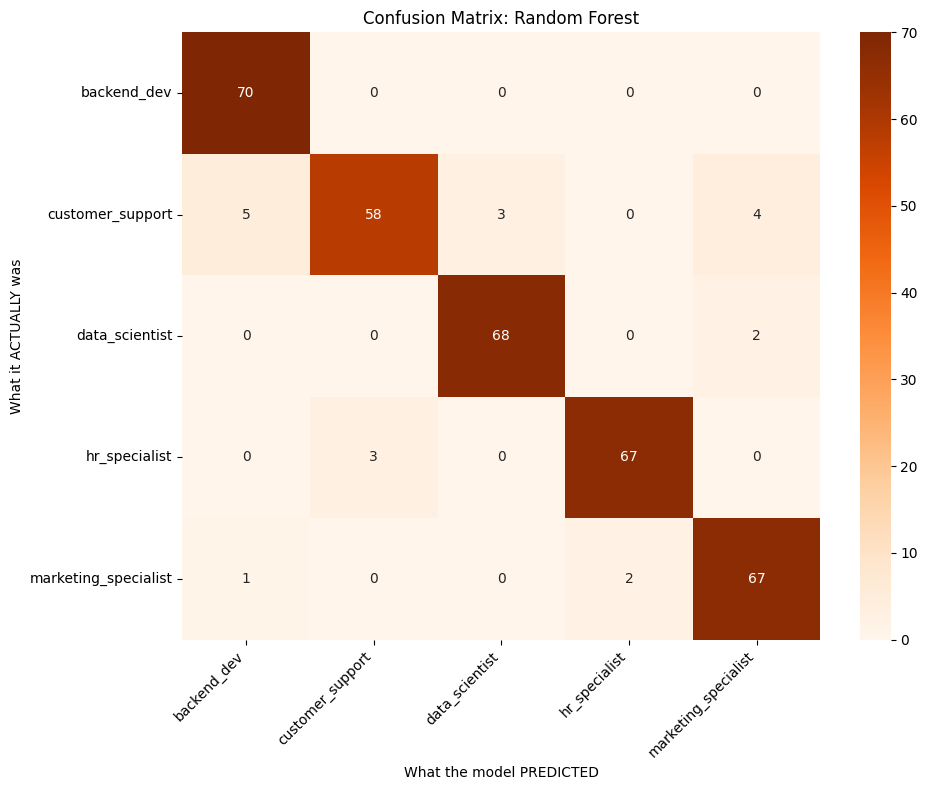

In [7]:
# ============================================================
# RANDOM FOREST CLASSIFIER
# ============================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import time

# --- STEP 1: Create the model ---
# We'll use 100 trees - a good starting point
rf_model = RandomForestClassifier(
    n_estimators=100,   # Create 100 different trees
    max_depth=None,     # Let trees grow as deep as needed
    random_state=42,    # For reproducible results
    n_jobs=-1           # Use all CPU cores to train faster
)

# --- STEP 2: Train the model ---
print("🌲 Training Random Forest (100 trees)...")
start_time = time.time()

rf_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"✅ Training completed in {training_time:.2f} seconds")

# --- STEP 3: Make predictions ---
y_pred_rf = rf_model.predict(X_test)

# --- STEP 4: Evaluate performance ---
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"\n📊 RESULTS: Random Forest")
print(f"{'='*50}")
print(f"Accuracy: {accuracy_rf:.4f} ({accuracy_rf*100:.1f}%)")

# Prepare the role names for the report (ensure they match IDs 0, 1, 2...)
# We use the 'id_to_role' dictionary from previous steps
target_names = [id_to_role[i] for i in sorted(id_to_role.keys())]

print(f"\nDetailed Metrics per Role:")
print(classification_report(y_test, y_pred_rf, target_names=target_names))

# --- STEP 5: Confusion Matrix ---
plt.figure(figsize=(10, 8))
cm_rf = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges',
            xticklabels=target_names,
            yticklabels=target_names)

plt.title('Confusion Matrix: Random Forest')
plt.xlabel('What the model PREDICTED')
plt.ylabel('What it ACTUALLY was')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Section 2.3 - YOUR TASK - Try using Neural Networks?
TODO, using **Pytorch**

In [8]:
# ============================================================
# NEURAL NETWORKS WITH PYTORCH - PART 1: UNDERSTANDING THE BASICS
# ============================================================
#
# WHY PYTORCH?
# ------------
# PyTorch is one of the most popular libraries for building neural networks.
# It's used by researchers and companies like Meta, Tesla, and OpenAI.
#
# WHAT'S DIFFERENT FROM SCIKIT-LEARN?
# -----------------------------------
# With scikit-learn (SVM, Random Forest), we just called .fit() and .predict()
# With PyTorch, we have more control but also more steps:
#
#   1. Prepare data in a special format (Tensors & DataLoaders)
#   2. Define the neural network architecture (how many layers, etc.)
#   3. Write a training loop (show data to network many times)
#   4. Evaluate on test data
#
# Don't worry - we'll go through each step carefully!
#
# ============================================================

import torch
import torch.nn as nn  # nn = "neural network" module
from torch.utils.data import Dataset, DataLoader

# Check if we have a GPU available (makes training faster)
# Don't worry if you don't have one - CPU works fine for this example!
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {device}")
if device.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
else:
    print("   (No GPU detected - using CPU, which is fine for this dataset!)")

🖥️ Using device: cpu
   (No GPU detected - using CPU, which is fine for this dataset!)


In [9]:
import torch
import numpy as np # Ensure numpy is imported

# ============================================================
# PART 2: CONVERTING DATA TO PYTORCH FORMAT (Tensors)
# ============================================================
#
# WHAT IS A TENSOR?
# -----------------
# A tensor is just a fancy word for "a box of numbers" that
# PyTorch can process very efficiently on a GPU/CPU.
#
# Examples:
#   - A single number (like 5) is a 0D tensor (scalar)
#   - A list [1, 2, 3] is a 1D tensor (vector)
#   - A table/grid is a 2D tensor (matrix)
#
# WHY DO WE NEED THIS?
# --------------------
# PyTorch models cannot read numpy arrays or pandas columns directly.
# We must convert our data into PyTorch's native format.
#
# ============================================================

# Step 1: Convert numpy arrays/pandas series to PyTorch tensors

# For inputs (X), we use float32 (standard for neural networks)
# X_train is likely already a numpy array from the split step
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# For labels (y), we use torch.long because they are integers (0, 1, 2...)
# ⚠️ FIX: We add .values to convert the Pandas Series to a Numpy Array first!
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

print(f"✅ Converted to PyTorch tensors")
print(f"   X_train_tensor shape: {X_train_tensor.shape}")
print(f"   y_train_tensor shape: {y_train_tensor.shape}")

# Quick sanity check: how many features and classes do we have?
num_features = X_train_tensor.shape[1]  # The size of the embedding (e.g., 768)
num_classes = len(id_to_role)           # Number of unique roles (employees)

print(f"\n📊 Summary:")
print(f"   Input Size (Embedding Dimensions): {num_features}")
print(f"   Output Size (Number of Classes):   {num_classes}")

✅ Converted to PyTorch tensors
   X_train_tensor shape: torch.Size([1400, 384])
   y_train_tensor shape: torch.Size([1400])

📊 Summary:
   Input Size (Embedding Dimensions): 384
   Output Size (Number of Classes):   5


In [10]:
# ============================================================
# PART 3: CREATING A DATASET AND DATALOADER
# ============================================================
#
# WHAT IS A DATASET?
# ------------------
# A Dataset is a container that holds your data and knows how to
# give you one sample at a time. Think of it like a filing cabinet
# where each drawer contains one example.
#
# WHAT IS A DATALOADER?
# ---------------------
# A DataLoader takes samples from the Dataset and groups them into
# "batches". Instead of training on one example at a time (slow!),
# we train on a batch of examples together (faster!).
#
# Example: If you have 400 training examples and batch_size=32,
# the DataLoader will give you 13 batches of 32 examples each.
#
# WHY BATCHES?
# ------------
# 1. Faster training (parallel processing)
# 2. More stable learning (averages out noise from individual examples)
# 3. Uses less memory than loading everything at once
#
# ============================================================

# Create a simple Dataset class
# This tells PyTorch how to access our data
class TaskDataset(Dataset):
    """
    A custom Dataset for our task classification problem.

    Required methods:
    - __init__: Set up the data
    - __len__: Return the total number of samples
    - __getitem__: Return one sample given an index
    """

    def __init__(self, features, labels):
        """
        Store our features (X) and labels (y).

        Args:
            features: The TF-IDF features (as a tensor)
            labels: The role labels (as a tensor)
        """
        self.features = features
        self.labels = labels

    def __len__(self):
        """Return how many samples we have."""
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Return one sample.

        Args:
            idx: Which sample to return (0, 1, 2, ...)

        Returns:
            A tuple of (features, label) for that sample
        """
        return self.features[idx], self.labels[idx]

# Create Dataset objects
train_dataset = TaskDataset(X_train_tensor, y_train_tensor)
test_dataset = TaskDataset(X_test_tensor, y_test_tensor)

print(f"✅ Created Datasets")
print(f"   Training samples: {len(train_dataset)}")
print(f"   Test samples: {len(test_dataset)}")

# Create DataLoaders
# batch_size=32 is a common choice - not too small, not too big
# shuffle=True for training (mix up the order each time)
# shuffle=False for testing (we want consistent results)
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✅ Created DataLoaders with batch_size={BATCH_SIZE}")
print(f"   Training batches: {len(train_loader)}")
print(f"   Test batches: {len(test_loader)}")

# Let's look at one batch to understand the shape
sample_features, sample_labels = next(iter(train_loader))
print(f"\n📦 One batch looks like:")
print(f"   Features shape: {sample_features.shape}  (batch_size x num_features)")
print(f"   Labels shape: {sample_labels.shape}  (batch_size,)")

✅ Created Datasets
   Training samples: 1400
   Test samples: 350

✅ Created DataLoaders with batch_size=32
   Training batches: 44
   Test batches: 11

📦 One batch looks like:
   Features shape: torch.Size([32, 384])  (batch_size x num_features)
   Labels shape: torch.Size([32])  (batch_size,)


In [11]:
# ============================================================
# PART 4: BUILDING THE NEURAL NETWORK (MLP)
# ============================================================
#
# WHAT IS AN MLP?
# ---------------
# MLP = Multi-Layer Perceptron (don't worry about the fancy name!)
#
# It's the simplest type of neural network:
#   Input → Hidden Layer(s) → Output
#
# Think of it like a series of transformations:
#   1. Take the input (text embeddings)
#   2. Transform it through hidden layers (learn patterns)
#   3. Output a prediction (which role?)
#
# WHAT'S A "LAYER"?
# -----------------
# A layer is a group of "neurons" that process data.
# Each layer transforms the data in some way.
#
# Example architecture for our problem:
#   Input (328 dimensions) → Hidden (128 neurons) → Hidden (64 neurons) → Output (5 classes)
#
# WHAT'S AN "ACTIVATION FUNCTION"?
# --------------------------------
# After each layer, we apply an activation function.
# It adds "non-linearity" - without it, the network would just be
# a fancy linear equation (no better than a straight line).
#
# We'll use ReLU (Rectified Linear Unit):
#   - If input > 0: output = input
#   - If input ≤ 0: output = 0
# Simple but effective!
#
# ============================================================

class SimpleMLP(nn.Module):
    """
    A simple Multi-Layer Perceptron for text classification.

    Architecture:
        Input → Linear → ReLU → Linear → ReLU → Linear → Output

    This is a 3-layer network (2 hidden layers + 1 output layer).
    """

    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        """
        Set up the layers of the network.

        Args:
            input_size: Number of input features (5000 TF-IDF features)
            hidden_size1: Number of neurons in first hidden layer
            hidden_size2: Number of neurons in second hidden layer
            num_classes: Number of output classes (roles to predict)
        """
        super(SimpleMLP, self).__init__()  # Required boilerplate

        # Define the layers
        # nn.Linear = a fully connected layer (every input connects to every output)
        self.layer1 = nn.Linear(input_size, hidden_size1)   # Input → Hidden1
        self.layer2 = nn.Linear(hidden_size1, hidden_size2) # Hidden1 → Hidden2
        self.layer3 = nn.Linear(hidden_size2, num_classes)  # Hidden2 → Output

        # Activation function (applied after each layer except the last)
        self.relu = nn.ReLU()

        # Dropout: randomly "turns off" some neurons during training
        # This prevents overfitting (memorizing instead of learning)
        # 0.5 = 50% of neurons are randomly turned off each time
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        """
        Define how data flows through the network.

        This is called automatically when you do: model(input)

        Args:
            x: Input tensor of shape (batch_size, input_size)

        Returns:
            Output tensor of shape (batch_size, num_classes)
        """
        # Layer 1: Linear → ReLU → Dropout
        x = self.layer1(x)      # Transform the input
        x = self.relu(x)        # Apply activation
        x = self.dropout(x)     # Apply dropout

        # Layer 2: Linear → ReLU → Dropout
        x = self.layer2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Layer 3: Linear (no activation - we'll apply softmax later)
        x = self.layer3(x)

        return x

# Create the model
model = SimpleMLP(
    input_size=num_features,    # 5000 TF-IDF features
    hidden_size1=128,           # First hidden layer: 128 neurons
    hidden_size2=64,            # Second hidden layer: 64 neurons
    num_classes=num_classes     # Output: one score per role
)

# Move model to GPU if available
model = model.to(device)

# Let's see what our model looks like!
print("🧠 MODEL ARCHITECTURE:")
print("=" * 50)
print(model)
print()

# Count the number of parameters (weights the model will learn)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"📊 Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")

🧠 MODEL ARCHITECTURE:
SimpleMLP(
  (layer1): Linear(in_features=384, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

📊 Total parameters: 57,861
   Trainable parameters: 57,861


In [12]:
# ============================================================
# PART 5: SETTING UP TRAINING (Loss Function & Optimizer)
# ============================================================
#
# To train a neural network, we need two things:
#
# 1. LOSS FUNCTION (also called "criterion")
#    ----------------------------------------
#    This measures "how wrong" the model's predictions are.
#
#    For classification, we use "Cross-Entropy Loss":
#    - If the model is confident AND correct → low loss
#    - If the model is confident AND wrong → high loss
#    - If the model is uncertain → medium loss
#
#    The goal of training is to MINIMIZE the loss.
#
# 2. OPTIMIZER
#    ---------
#    This decides HOW to update the model's weights to reduce the loss.
#
#    We use "Adam" optimizer - it's like a smart version of gradient descent:
#    - Automatically adjusts how fast to learn for each parameter
#    - Works well out-of-the-box (no manual tuning needed)
#
#    "Learning rate" = how big of a step to take when updating weights
#    - Too high: Model overshoots and never converges
#    - Too low: Training takes forever
#    - 0.001 is a good default starting point
#
# ============================================================

# Loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam with learning rate 0.001
# model.parameters() tells Adam which values to update
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("✅ Training setup complete!")
print(f"   Loss function: CrossEntropyLoss")
print(f"   Optimizer: Adam")
print(f"   Learning rate: {learning_rate}")

✅ Training setup complete!
   Loss function: CrossEntropyLoss
   Optimizer: Adam
   Learning rate: 0.001


In [13]:
# ============================================================
# PART 6: THE TRAINING LOOP
# ============================================================
#
# Training a neural network is an iterative process:
#
# For each EPOCH (one pass through all training data):
#     For each BATCH of data:
#         1. Forward pass: Get predictions from the model
#         2. Calculate loss: How wrong were we?
#         3. Backward pass: Calculate gradients (which direction to update)
#         4. Update weights: Adjust model parameters to reduce loss
#
# WHAT'S AN EPOCH?
# ----------------
# One epoch = showing the model ALL training examples once.
# We usually need multiple epochs because the model improves gradually.
#
# Think of it like studying for an exam:
# - Epoch 1: Read the textbook once (learn basic patterns)
# - Epoch 2: Read again (reinforce understanding)
# - Epoch 10: Know it well (converged)
#
# ============================================================

def train_one_epoch(model, data_loader, criterion, optimizer, device):
    """
    Train the model for one epoch.

    Args:
        model: The neural network
        data_loader: Provides batches of training data
        criterion: Loss function
        optimizer: Updates the weights
        device: CPU or GPU

    Returns:
        Average loss for this epoch
    """
    model.train()  # Set model to training mode (enables dropout)
    total_loss = 0

    for batch_features, batch_labels in data_loader:
        # Move data to the same device as the model
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        # STEP 1: Forward pass - get predictions
        outputs = model(batch_features)

        # STEP 2: Calculate loss
        loss = criterion(outputs, batch_labels)

        # STEP 3: Backward pass - calculate gradients
        optimizer.zero_grad()  # Clear old gradients (important!)
        loss.backward()        # Calculate new gradients

        # STEP 4: Update weights
        optimizer.step()

        total_loss += loss.item()

    # Return average loss per batch
    return total_loss / len(data_loader)


def evaluate(model, data_loader, device):
    """
    Evaluate the model on a dataset (no training, just predictions).

    Args:
        model: The neural network
        data_loader: Provides batches of test data
        device: CPU or GPU

    Returns:
        Accuracy (0 to 1)
    """
    model.eval()  # Set model to evaluation mode (disables dropout)
    correct = 0
    total = 0

    # torch.no_grad() means "don't calculate gradients" (faster, less memory)
    with torch.no_grad():
        for batch_features, batch_labels in data_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            # Get predictions
            outputs = model(batch_features)

            # Convert outputs to class predictions
            # outputs shape: (batch_size, num_classes)
            # We take the class with highest score as the prediction
            _, predicted = torch.max(outputs, 1)

            # Count correct predictions
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

    return correct / total


print("✅ Training functions defined!")

✅ Training functions defined!


In [14]:
# ============================================================
# PART 7: TRAINING THE MODEL
# ============================================================
#
# Now we put it all together and train for multiple epochs!
# We'll track both loss and accuracy to see how the model improves.
#
# ============================================================

import time

# Training settings
NUM_EPOCHS = 10  # How many times to go through the entire dataset

# Storage for plotting
train_losses = []
train_accuracies = []
test_accuracies = []

print("🚀 Starting training...")
print("=" * 60)

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    # Train for one epoch
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Evaluate on training and test sets
    train_acc = evaluate(model, train_loader, device)
    test_acc = evaluate(model, test_loader, device)

    # Save for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    # Print progress every 5 epochs (or first and last)
    if epoch == 0 or (epoch + 1) % 5 == 0 or epoch == NUM_EPOCHS - 1:
        print(f"Epoch [{epoch+1:2d}/{NUM_EPOCHS}] | "
              f"Loss: {train_loss:.4f} | "
              f"Train Acc: {train_acc*100:.1f}% | "
              f"Test Acc: {test_acc*100:.1f}%")

total_time = time.time() - start_time
print("=" * 60)
print(f"✅ Training completed in {total_time:.1f} seconds")
print(f"\n📊 FINAL RESULTS:")
print(f"   Final Training Accuracy: {train_accuracies[-1]*100:.1f}%")
print(f"   Final Test Accuracy: {test_accuracies[-1]*100:.1f}%")

# Save accuracy for comparison later
accuracy_mlp = test_accuracies[-1]

🚀 Starting training...
Epoch [ 1/10] | Loss: 1.5508 | Train Acc: 85.9% | Test Acc: 82.9%
Epoch [ 5/10] | Loss: 0.1697 | Train Acc: 97.8% | Test Acc: 95.7%
Epoch [10/10] | Loss: 0.0577 | Train Acc: 99.9% | Test Acc: 95.4%
✅ Training completed in 1.5 seconds

📊 FINAL RESULTS:
   Final Training Accuracy: 99.9%
   Final Test Accuracy: 95.4%


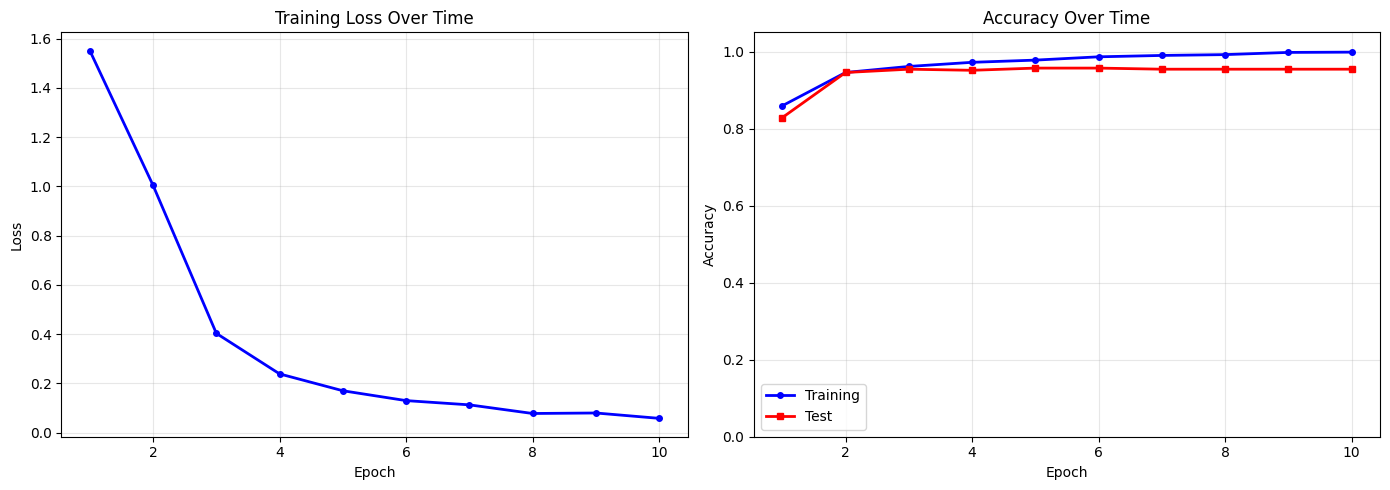

✅ Train and test accuracy are close - no significant overfitting!


In [15]:
# ============================================================
# PART 8: VISUALIZING TRAINING PROGRESS
# ============================================================
#
# Let's see how the model improved over time!
#
# Good signs:
# - Loss going DOWN over epochs
# - Accuracy going UP over epochs
# - Train and Test accuracy are close (no overfitting)
#
# Bad signs:
# - Train accuracy is high but Test accuracy is low → Overfitting!
#   (Model memorized training data but doesn't generalize)
#
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss over epochs
axes[0].plot(range(1, NUM_EPOCHS + 1), train_losses, 'b-', linewidth=2, marker='o', markersize=4)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Over Time')
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy over epochs
axes[1].plot(range(1, NUM_EPOCHS + 1), train_accuracies, 'b-', linewidth=2, marker='o', markersize=4, label='Training')
axes[1].plot(range(1, NUM_EPOCHS + 1), test_accuracies, 'r-', linewidth=2, marker='s', markersize=4, label='Test')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

# Check for overfitting
if train_accuracies[-1] - test_accuracies[-1] > 0.1:
    print("⚠️ Warning: Gap between train and test accuracy is large!")
    print("   This suggests OVERFITTING - the model memorized the training data.")
    print("   Consider: more dropout, less epochs, or more training data.")
else:
    print("✅ Train and test accuracy are close - no significant overfitting!")

📊 DETAILED RESULTS: Neural Network (MLP)
Accuracy: 0.9543 (95.4%)

Detailed Metrics per Role:
                      precision    recall  f1-score   support

         backend_dev       0.92      1.00      0.96        70
    customer_support       0.94      0.90      0.92        70
      data_scientist       0.99      0.96      0.97        70
       hr_specialist       0.97      0.94      0.96        70
marketing_specialist       0.96      0.97      0.96        70

            accuracy                           0.95       350
           macro avg       0.95      0.95      0.95       350
        weighted avg       0.95      0.95      0.95       350



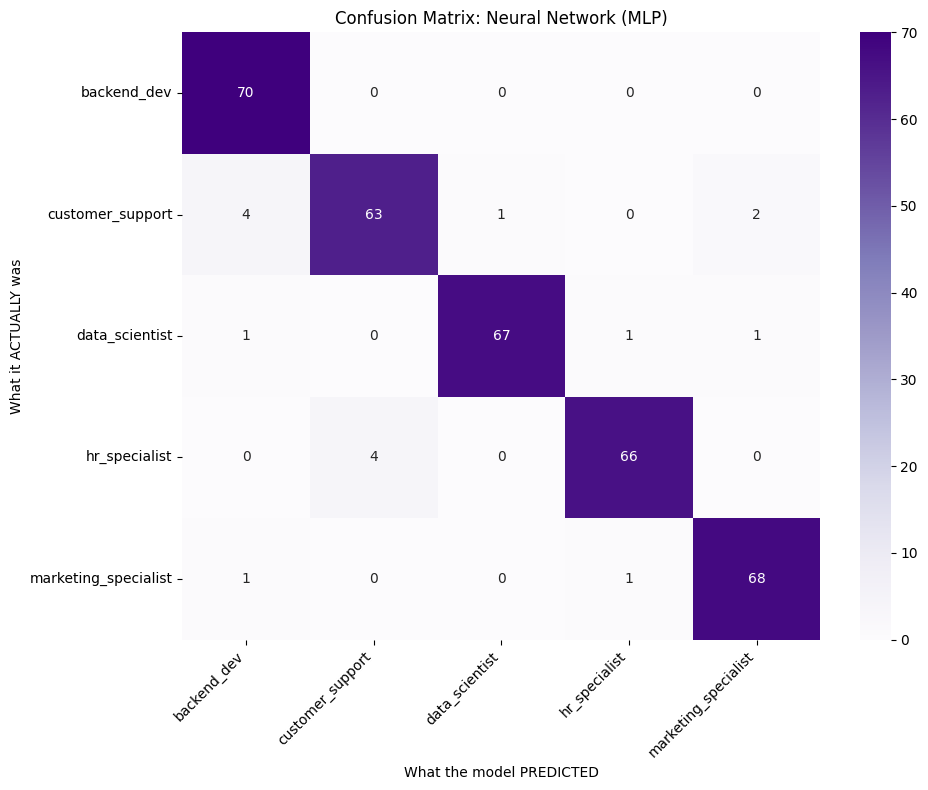

In [16]:
# ============================================================
# PART 9: DETAILED EVALUATION & CONFUSION MATRIX
# ============================================================
#
# Let's get the detailed classification report and confusion matrix,
# just like we did for SVM and Random Forest.
#
# ============================================================

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Get all predictions for the test set
model.eval()  # Set the model to evaluation mode
all_predictions = []
all_labels = []

with torch.no_grad():  # Turn off gradient calculation (saves memory)
    for batch_features, batch_labels in test_loader:
        # Move features to the same device as the model (CPU or GPU)
        batch_features = batch_features.to(device)

        # Ask the model for predictions
        outputs = model(batch_features)

        # Convert raw scores to actual class predictions (0, 1, 2...)
        _, predicted = torch.max(outputs, 1)

        # Move back to CPU and convert to numpy for reporting
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_labels.numpy())

# 2. Convert lists to simple numpy arrays
y_pred_mlp = np.array(all_predictions)
y_true_mlp = np.array(all_labels)

# 3. Calculate Accuracy
accuracy_mlp = accuracy_score(y_true_mlp, y_pred_mlp)

# 4. Print classification report
print("📊 DETAILED RESULTS: Neural Network (MLP)")
print("=" * 50)
print(f"Accuracy: {accuracy_mlp:.4f} ({accuracy_mlp*100:.1f}%)")

# Prepare role names for the report
target_names = [id_to_role[i] for i in sorted(id_to_role.keys())]

print(f"\nDetailed Metrics per Role:")
print(classification_report(y_true_mlp, y_pred_mlp, target_names=target_names))

# 5. Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
cm_mlp = confusion_matrix(y_true_mlp, y_pred_mlp)

sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Purples',
            xticklabels=target_names,
            yticklabels=target_names)

plt.title('Confusion Matrix: Neural Network (MLP)')
plt.xlabel('What the model PREDICTED')
plt.ylabel('What it ACTUALLY was')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Section 2.4 - YOUR TASK - Compare and choose the best model
TODO, using **Pytorch**

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, classification_report

# ==========================================
# 1. Prepare the Numeric Data
# ==========================================
# We use np.vstack to turn the list of arrays into a proper 2D matrix
X = np.vstack(df['task_embedding'].values)
y = df['employee_id']

# Split: 70% Train, 30% Test
# 'stratify=y' ensures every role is represented equally in the test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ==========================================
# 2. Define Models
# ==========================================
models = {
    # 1. SVM (Linear): Best for high-dimensional, linearly separable data
    "SVM (Linear)": SVC(
        kernel='linear',
        probability=True,
        random_state=42
    ),

    # 2. SVM (RBF): Uses curved boundaries to find non-linear relationships
    "Random forest": SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        probability=True,
        random_state=42
    ),

    # 3. Neural Network (MLP): Deep learning approach for complex patterns
    "Neural Network (MLP)": MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        max_iter=1000,
        random_state=42
    )
}

# ==========================================
# 3. Training and Evaluation Loop
# ==========================================
best_f1 = 0
best_model_name = ""
best_model = None

# We can get the names of the roles for a nicer report
target_names = sorted(df['role'].unique())

print("🚀 Starting Model Comparison...\n")

for name, model in models.items():
    # A. Train
    model.fit(X_train, y_train)

    # B. Predict
    preds = model.predict(X_test)

    # C. Score
    f1 = f1_score(y_test, preds, average='weighted')

    print(f"✅ {name} | Weighted F1-Score: {f1:.4f}")
    print(classification_report(y_test, preds, target_names=target_names, zero_division=0))
    print("-" * 60)

    # D. Track Winner
    if f1 > best_f1:
        best_f1 = f1
        best_model_name = name
        best_model = model

print(f"\n🏆 WINNER: {best_model_name} (F1: {best_f1:.4f})")

🚀 Starting Model Comparison...

✅ SVM (Linear) | Weighted F1-Score: 0.9658
                      precision    recall  f1-score   support

         backend_dev       0.95      1.00      0.98       105
    customer_support       0.93      0.94      0.93       105
      data_scientist       0.98      0.96      0.97       105
       hr_specialist       1.00      0.95      0.98       105
marketing_specialist       0.97      0.97      0.97       105

            accuracy                           0.97       525
           macro avg       0.97      0.97      0.97       525
        weighted avg       0.97      0.97      0.97       525

------------------------------------------------------------
✅ Random forest | Weighted F1-Score: 0.9732
                      precision    recall  f1-score   support

         backend_dev       0.96      1.00      0.98       105
    customer_support       0.95      0.93      0.94       105
      data_scientist       0.99      0.99      0.99       105
       hr_

## 🚀 Section 3: The Integrated Manager App

This cell launches the interface. The "Magic" happens in the orchestrator function, which connects the External Service (Extraction) to Your Brain (Classification).

### Section 3.1 - YOUR TASK - Launch the inference in the app

> ⚠️ **Warning:**
> Make sure that you saved your model in the `best_model` variable before running the app.


In [19]:
#@title Run the Web app { display-mode: "form" }

import pandas as pd
import json
import IPython

# Load the datasets from your Drive path
DATASET_PATH = "/content/drive/MyDrive/BMAI/week1/task_meeting/data"
df_meetings = pd.read_pickle(f"{DATASET_PATH}/employee_tasks_meeting_id_transcripts.pkl")
df_tasks = pd.read_pickle(f"{DATASET_PATH}/employee_tasks_meeting_id.pkl")

def getMeetingMinutes(meeting_id):
    """
    Fetches the transcript for a specific meeting ID.
    Note: meeting_id comes from JS as an integer.
    """
    # Filter for the specific meeting
    meeting_row = df_meetings[df_meetings['meeting_id'] == int(meeting_id)]

    if meeting_row.empty:
        return {'error': 'Meeting not found', 'meeting_id': meeting_id}

    # Return a dictionary (Colab bridge handles the conversion to JS object)
    return meeting_row.iloc[0]['transcription']


def assignTasks(meeting_id):
    """
    Finds tasks associated with a meeting and returns structured employee assignments.
    """
    # 1. Get tasks for this meeting
    tasks_for_meeting = df_tasks[df_tasks['meeting_id'] == int(meeting_id)]

    response_list = []

    for _, row in tasks_for_meeting.iterrows():
        # Here you would normally run: predictions = best_model.predict(row['task_embedding'])
        # For this example, we use the data already in the CSV

        task_info = {
            "task": row['task_description'],
            "owner_id": int(row['employee_id']),
            "owner_name": f"Employee {row['employee_id']}", # Replace with name lookup if available
            "role": row['role'],
            # "embedding": row['task_embedding']
        }
        response_list.append(task_info)

    # Returning a list of dicts is the safest way to avoid escaping issues in Colab
    return json.dumps(response_list)

# Register these so JS can see them
from google.colab import output
output.register_callback('getMeetingMinutes', getMeetingMinutes)
output.register_callback('assignTasks', assignTasks)

# --- THE WEB INTERFACE ---
url = f"https://raw.githubusercontent.com/eth-bmai-fs26/project/refs/heads/{BRANCH}/week1/task_meeting/task_assigner_app_colab.html"
response = requests.get(url)
response.raise_for_status() # Check for 404/500 errors
html_app = response.text
IPython.display.display(IPython.display.HTML(html_app))